# Libraries

In [43]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
from math import sqrt

# reading data
import os
import json
from collections import defaultdict

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from masking import TriangularCausalMask, ProbMask

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

%store -r Kelmarsh_df Penmanshiel_df


# Architektur

### Embedding

probabilistic embedding & positional encoding

In [44]:
test_df = Kelmarsh_df['1'][['# Date and time', 'Energy Export (kWh)']][-1024:]

# First, ensure that the column is in datetime format
test_df['# Date and time'] = pd.to_datetime(test_df['# Date and time'])

# Then convert it to timestamps
test_df['Timestamp'] = test_df['# Date and time'].apply(lambda x: x.timestamp())

# interpolate NaN values
test_df = test_df.interpolate(method='linear')

features_matrix = test_df[['Energy Export (kWh)', 'Timestamp']].values

In [45]:
def t2v(
    tau, # input tensor
    f, # activation function (sin or cosin)
    out_features, # size of output vector
    w, # weights
    b, # biases
    w0, # weights for linear part of time2vec layer
    b0, # biases for linear part of time2vec layer
    arg=None # optional arguments
    ):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0

    return torch.cat([v1, v2], -1)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class CosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(CosineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.cos

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

if __name__ == "__main__":
    sineact = SineActivation(2, 64)
    cosact = CosineActivation(2, 64)

feature_tensor = torch.tensor(features_matrix, dtype=torch.float32)
# check for NaN values early
if torch.isnan(feature_tensor).any():
    raise ValueError('NaN values detected in Input')
    
t2v_tensor = sineact(feature_tensor)

print(t2v_tensor.shape)

torch.Size([1024, 64])


In [46]:
def t2v(
    tau, # input tensor
    f, # activation function (sin or cosin)
    out_features, # size of output vector
    w, # weights
    b, # biases
    w0, # weights for linear part of time2vec layer
    b0, # biases for linear part of time2vec layer
    arg=None # optional arguments
    ):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        #print(w.shape, t1.shape, b.shape)
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    #print(v1.shape)
    return torch.cat([v1, v2], -1)

class ProbabilisticSineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProbabilisticSineActivation, self).__init__()
        self.out_features = out_features // 2  # Half for mean, half for variance
        self.w0 = nn.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w = nn.Parameter(torch.randn(in_features, self.out_features - 1))
        self.b = nn.Parameter(torch.randn(self.out_features - 1))
        self.f = torch.sin

    def forward(self, tau):
        # Calculate mean
        mean = t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)
        
        # Calculate variance (use another set of weights and biases, ensure positive variance)
        variance = F.softplus(t2v(tau, self.f, self.out_features, 
                                  torch.randn_like(self.w), torch.randn_like(self.b), 
                                  torch.randn_like(self.w0), torch.randn_like(self.b0)))
        
        return torch.cat([mean, variance], -1)

class ProbabilisticCosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProbabilisticCosineActivation, self).__init__()
        self.out_features = out_features // 2  # Half for mean, half for variance
        self.w0 = nn.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w = nn.Parameter(torch.randn(in_features, self.out_features - 1))
        self.b = nn.Parameter(torch.randn(self.out_features - 1))
        self.f = torch.cos

    def forward(self, tau):
        # Calculate mean
        mean = t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)
        
        # Calculate variance (use another set of weights and biases, ensure positive variance)
        variance = F.softplus(t2v(tau, self.f, self.out_features, 
                                  torch.randn_like(self.w), torch.randn_like(self.b), 
                                  torch.randn_like(self.w0), torch.randn_like(self.b0)))
        
        return torch.cat([mean, variance], -1)

if __name__ == "__main__":
    prob_sineact = ProbabilisticSineActivation(2, 64)
    prob_cosact = ProbabilisticCosineActivation(2,64)

    feature_tensor = torch.tensor(features_matrix, dtype=torch.float32)
    # check for NaN values early
    if torch.isnan(feature_tensor).any():
        raise ValueError('NaN values detected in Input Tensor')

    prob_embeddings = prob_sineact(feature_tensor)

    # check for NaN values early
    if torch.isnan(prob_embeddings).any():
        raise ValueError('NaN values detected in probabilistic Embeddings')

    # Ensure prob_embeddings has the correct shape [B, L, E]
    if len(prob_embeddings.shape) == 2:
        prob_embeddings = prob_embeddings.unsqueeze(0)  # Add batch dimension

    elif len(prob_embeddings.shape) == 1:
        prob_embeddings = prob_embeddings.unsqueeze(0).unsqueeze(0)  # Add batch and length dimensions

    # prob_embeddings now contains both mean and variance for each feature
    print(prob_embeddings.shape)  # Should be [batch_size, 64] (32 for mean, 32 for variance)

torch.Size([1, 1024, 64])


### Feed Forward 

##### Sparse Attention

Credit to [Informer](https://github.com/zhouhaoyi/Informer2020/blob/0ac81e04d4095ecb97a3a78c7b49c936d8aa9933/models/attn.py#L38)

In [47]:
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)
        
        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2,1)
        keys = keys.transpose(2,1)
        values = values.transpose(2,1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q) 

        U_part = U_part if U_part<L_K else L_K
        u = u if u<L_Q else L_Q
        
        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u) 

        # add scale factor
        scale = self.scale or 1./sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)
        
        return context.transpose(2,1).contiguous(), attn


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, 
                 d_keys=None, d_values=None, mix=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        self.mix = mix

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        if self.mix:
            out = out.transpose(2,1).contiguous()
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [48]:
class SparseAttentionModule(nn.Module):
    def __init__(self, d_model, n_heads, prob_sparse_factor=5, attention_dropout=0.1):
        super(SparseAttentionModule, self).__init__()
        self.attention_layer = AttentionLayer(
            ProbAttention(mask_flag=True, factor=prob_sparse_factor, scale=None, attention_dropout=attention_dropout),
            d_model=d_model, n_heads=n_heads
        )

    def forward(self, embeddings):
        # Assuming embeddings are concatenated means and variances
        # Split embeddings into mean and variance
        means, variances = embeddings.split(embeddings.shape[-1] // 2, dim=-1)

        # Use means for attention calculation
        attention_output, _ = self.attention_layer(means, means, means, None)

        return attention_output

# Example usage
model = SparseAttentionModule(
    d_model=(prob_embeddings.shape[-1] // 2),
    n_heads=3,
    prob_sparse_factor=5
    )

# Ensure prob_embeddings has the correct shape [B, L, E]
if len(prob_embeddings.shape) == 2:
    prob_embeddings = prob_embeddings.unsqueeze(0)  # Add batch dimension

elif len(prob_embeddings.shape) == 1:
    prob_embeddings = prob_embeddings.unsqueeze(0).unsqueeze(0)  # Add batch and length dimensions

output = model(prob_embeddings)

# check for NaN values early
if torch.isnan(output).any():
    raise ValueError('NaN values detected in ProbSparse Output')


Processing mean and variance:

- Separate Attention Layers: The model now has separate attention layers for processing means and variances. This allows each component to be updated based on its own dynamics.
- Processing Means and Variances: Both components are processed through their respective attention layers.
- Combining Outputs: The outputs (updated means and variances) are then concatenated to form the final output tensor.

In [49]:
class SparseAttentionModule(nn.Module):
    def __init__(self, d_model, n_heads, prob_sparse_factor=5, attention_dropout=0.1):
        super(SparseAttentionModule, self).__init__()
        # Attention layers for both means and variances
        self.attention_layer_means = AttentionLayer(
            ProbAttention(mask_flag=True, factor=prob_sparse_factor, scale=None, attention_dropout=attention_dropout),
            d_model=d_model, n_heads=n_heads
        )
        self.attention_layer_vars = AttentionLayer(
            ProbAttention(mask_flag=True, factor=prob_sparse_factor, scale=None, attention_dropout=attention_dropout),
            d_model=d_model, n_heads=n_heads
        )

    def forward(self, embeddings):
        # Split embeddings into mean and variance
        means, variances = embeddings.split(embeddings.shape[-1] // 2, dim=-1)

        # Process means and variances separately through attention layers
        attention_output_means, _ = self.attention_layer_means(means, means, means, None)
        attention_output_vars, _ = self.attention_layer_vars(variances, variances, variances, None)

        # Combine the results
        combined_output = torch.cat([attention_output_means, attention_output_vars], dim=-1)

        return combined_output

# Example usage
model = SparseAttentionModule(
    d_model=(prob_embeddings.shape[-1] // 2),
    n_heads=3,
    prob_sparse_factor=5
    )
output_mean_var = model(prob_embeddings)

# check for NaN values early
if torch.isnan(output_mean_var).any():
    raise ValueError('NaN values detected in ProbSparse Output')

In [50]:
print(output.shape)
print(output_mean_var.shape)

torch.Size([1, 1024, 32])
torch.Size([1, 1024, 64])


##### Autocorrelation Attention

Credit to [Autoformer](https://github.com/thuml/Autoformer/blob/main/layers/AutoCorrelation.py)

In [8]:
class MovingAvg(nn.Module):
    """
    Moving average block to highlight the trend of time series.
    """
    def __init__(self, kernel_size, stride=1):
        super(MovingAvg, self).__init__()
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2)

    def forward(self, x):
        x = self.avg(x.permute(0, 2, 1))
        return x.permute(0, 2, 1)

class SeriesDecomp(nn.Module):
    """
    Series decomposition block for extracting trend and seasonal components.
    """
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.moving_avg = MovingAvg(kernel_size)

    def forward(self, x):
        trend = self.moving_avg(x)
        seasonal = x - trend
        return seasonal, trend

class TriangularCausalMask():
    """ 
    Masking the future data points using a triangle.
    """ 
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

In [70]:
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        self._mask = torch.triu(torch.ones((L, L), dtype=torch.bool), diagonal=1).to(device)
        self._mask = self._mask.unsqueeze(0).unsqueeze(1)  # Shape: [1, 1, L, L]
        self._mask = self._mask.repeat(B, 1, 1, 1)  # Repeat for batch and head dimensions

    @property
    def mask(self):
        return self._mask


In [71]:
# initialize layer
series_decomp_layer = SeriesDecomp(kernel_size=7) 

# split mean and variance
means, variances = prob_embeddings.split(prob_embeddings.shape[-1] // 2, dim=-1)

# apply decomposition
seasonal_means, trend_means = series_decomp_layer(means)
seasonal = torch.cat([seasonal_means, variances], dim=-1)
trend = torch.cat([trend_means, variances], dim=-1)

- Scoring Network: The ScoringNetwork is a simple linear layer followed by a sigmoid activation. It outputs scores for each element in the input sequence.
- ProbMask Class: This class now includes the scoring network. It takes an input sequence, computes scores, selects the top-k scores to generate indices, and then creates the probabilistic mask based on these indices.
- Forward Method: The forward method of ProbMask handles the entire process of scoring, index selection, and mask generation.

In [76]:
class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False, top_k=2):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        self.top_k = top_k

    def time_delay_agg(self, values, corr):
        """
        Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = self.top_k
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)

        print(f"corr Sample:", corr[0,0,0, :10])
        weights, delay = torch.topk(corr, self.top_k, dim=-1)

        # Reshape delay and weights dynamically
        delay = delay.reshape(batch, head, self.top_k, length)
        weights = weights.reshape(batch, head, self.top_k, length)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(init_index).float()

        for i in range(self.top_k):
            tmp_delay = init_index.expand_as(delay) + delay[..., i].unsqueeze(-1)
            tmp_delay = torch.clamp(tmp_delay, min=0, max=length-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))

        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, n=L, dim=-1)

        # Ensure corr has the shape [B, H, L, L]
        corr = corr.unsqueeze(2)
        expand_multiplier = L // corr.shape[3]
        corr = corr.expand(-1, -1, expand_multiplier, -1, -1)
        corr = corr.reshape(
            corr.shape[0],
            corr.shape[1],
            L,
            corr.shape[-1]
        )

        # Create and apply the mask
        if self.mask_flag:
            mask = TriangularCausalMask(B, L, device=queries.device).mask
            mask = mask.expand(-1, H, -1, -1)  # Shape: [B, H, L, L]
            print(f"after masking:", mask[0,0,5, :10])
            corr = corr.masked_fill(mask, 0)  # Zero out the masked positions

        print(f"corr after masking:", corr[0,0,0, :10])

        # time delay aggregation
        V = self.time_delay_agg(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        # time delay agg
        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)

class AutoCorrelationLayer(nn.Module):
    def __init__(self, auto_corr, d_model, n_heads):
        super(AutoCorrelationLayer, self).__init__()
        # initialize AutoCorr
        self.auto_corr = auto_corr 

    def forward(self, queries, keys, values, attn_mask):
        # Use the provided AutoCorrelation instance
        return self.auto_corr(queries, keys, values, attn_mask)

class MyAutoCorrelationModel(nn.Module):
    def __init__(self, d_model, n_heads, B, L, input_dim, top_k=2, device="cpu"):
        super(MyAutoCorrelationModel, self).__init__()

        # Create the AutoCorrelationLayer with the AutoCorrelation instance
        self.n_heads = n_heads
        self.auto_corr = AutoCorrelation(top_k=top_k)
        self.auto_corr_layer = AutoCorrelationLayer(self.auto_corr, d_model, n_heads)
        self.top_k = top_k

    def forward(self, prob_embeddings):
        H = self.n_heads
        E = input_dim // H # size per head

        # Ensure that E is an even number
        if input_dim % H != 0:
            raise ValueError("Half the feature dimension is not divisible by the number of heads.")

        # Split tensor into means and variances
        means, variances = prob_embeddings.split(input_dim, dim=-1)

        # Reshape both halves for multi-head format: [B, L, H, E]
        reshaped_means = means.view(B, L, H, E)
        reshaped_variances = variances.view(B, L, H, E)

        # Concatenate the reshaped means and variances
        reshaped_embeddings = torch.cat([reshaped_means, reshaped_variances], dim=-1)

        return self.auto_corr_layer(reshaped_embeddings, reshaped_embeddings, reshaped_embeddings, None)[0]

# Example usage
B, L, _ = prob_embeddings.shape
input_dim = prob_embeddings.shape[-1] // 2  # Assuming this matches your input dimension

model = MyAutoCorrelationModel(
    d_model=input_dim,
    n_heads=4,
    B=B,
    L=L,
    input_dim=input_dim,
    top_k=2,  # Adjust as needed
    device=prob_embeddings.device
)

output = model(prob_embeddings)

after masking: tensor([False, False, False, False, False, False,  True,  True,  True,  True])
corr after masking: tensor([526.7306,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000], grad_fn=<SliceBackward0>)
corr Sample: tensor([526.7306,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000], grad_fn=<SliceBackward0>)


In [53]:
prob_embeddings.shape

torch.Size([1, 1024, 64])

### Loss Criterion

In [15]:
# CRPS (continouos ranked probability score)
def crps(forecast, observations, weights):
    """
    Args:
    forecast (pd.DataFrame or np.ndarray): Forecasts from the model (ensemble).
    observations (pd.Series or np.ndarray): Observed values.
    weights (np.array): Corresponding weights for the CRPS scores, derived from sparse attention.

    Returns:
    float: Weighted mean of the CRPS for all forecasts.
    """
    # Convert to NumPy arrays if input is Pandas
    if isinstance(forecast, pd.DataFrame):
        forecast = forecast.to_numpy()
    if isinstance(observations, pd.Series):
        observations = observations.to_numpy()
    
    # Sort forecast samples
    forecast.sort(axis=0)

    # Ensure observations are broadcastable over the forecast_samples
    observations = observations[np.newaxis, :]

    # Calculate CRPS
    cumsum_forecast = np.cumsum(forecast, axis=0) / forecast.shape[0]
    crps = np.mean((cumsum_forecast - (forecast > observations).astype(float)) ** 2, axis=0)
    
    # weighted median of CRPS
    if len(crps) != len(weights):
        raise ValueError("Length of CRPS series and weights must be equal")

    weighted_sum = np.sum(crps * weights)
    total_weights = np.sum(weights)

    if total_weights == 0:
        raise ValueError("Total weight cannot be zero")

    weighted_crps = weighted_sum / total_weights
    
    return round(weighted_crps, 4)

# Example usage
forecast_samples = pd.DataFrame(np.random.randn(1000, 5))  # Example forecast samples
observations = pd.Series(np.random.randn(5))  # Example observations
weights = np.random.rand(5)  # Example weights

weighted_crps = crps(forecast_samples, observations, weights)
print("Weighted Mean CRPS:", weighted_crps)

Weighted Mean CRPS: 1.3489


# Test Area

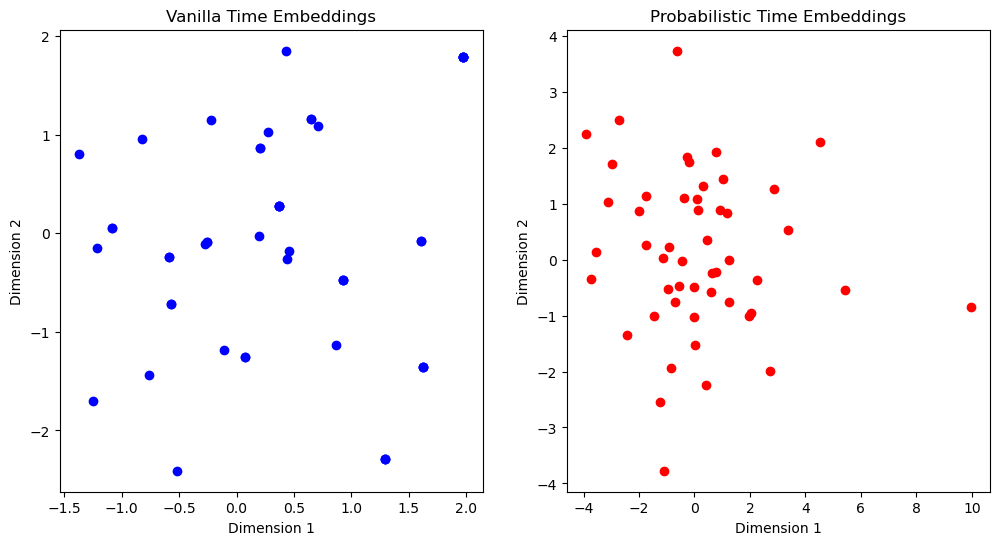

In [ ]:
# Vanilla Embedding
class VanillaTimeEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

# Probabilistic Time Embedding
class ProbabilisticTimeEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.mu = nn.Embedding(num_embeddings, embedding_dim)
        self.log_sigma = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)
        sigma = torch.exp(log_sigma)
        return mu + sigma * torch.randn_like(sigma)

# Generate some random indices to simulate time steps
time_indices = torch.tensor(np.random.randint(0, 50, size=50))

# Initialize models
vanilla_model = VanillaTimeEmbedding(50, 2)
probabilistic_model = ProbabilisticTimeEmbedding(50, 2)

# Get embeddings
vanilla_embeddings = vanilla_model(time_indices).detach().numpy()
probabilistic_embeddings = probabilistic_model(time_indices).detach().numpy()

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(vanilla_embeddings[:, 0], vanilla_embeddings[:, 1], c='blue')
plt.title('Vanilla Time Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplot(1, 2, 2)
plt.scatter(probabilistic_embeddings[:, 0], probabilistic_embeddings[:, 1], c='red')
plt.title('Probabilistic Time Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()


### AutoCorr Layers

In [ ]:
class seasonal_layer(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

In [ ]:
class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with seasonal decomposition and masking.
    """
    def __init__(self, d_model, max_lag=1, mask_type='triangular', factor=1, scale=None, attention_dropout=0.1, output_attention=False, moving_avg_kernel=25, device="cpu"):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_type = mask_type
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        self.seasonal_decomp = SeriesDecomp(moving_avg_kernel)
        self.device = device
        self.d_model = d_model
        self.max_lag = max_lag

    def forward(self, queries, keys, values, attn_mask=None):
        B, L, _ = queries.shape

        # Apply seasonal decomposition
        seasonal, trend = self.seasonal_decomp(values)

        # Choose masking approach
        if self.mask_type == 'triangular':
            mask = TriangularCausalMask(B, L, device=self.device).mask
        elif self.mask_type == 'prob':
            # ProbMask requires additional inputs like scores and index
            # Assuming scores and index are provided in some way
            scores = ... # Define or obtain scores
            index = ...  # Define or obtain index
            mask = ProbMask(B, self.d_model, L, index, scores, device=self.device).mask
        else:
            raise ValueError("Invalid mask type")

        # Apply mask if provided
        if attn_mask is not None:
            mask = mask & attn_mask

        # Compute time-lagged correlations
        lagged_correlation = torch.zeros_like(queries)
        for lag in range(1, self.max_lag + 1):
            lagged_correlation += torch.roll(queries, shifts=lag, dims=-1) * keys

        # Normalize the correlation
        lagged_correlation /= self.max_lag

        # Processed values
        processed_values = self.dropout(lagged_correlation)

        # Return the processed values and optionally the correlation coefficients
        if self.output_attention:
            return processed_values, lagged_correlation
        else:
            return processed_values, None

In [ ]:


# probabilistic masking
class ProbMask(nn.Module):
    def __init__(self, B, H, L, input_dim, top_k=5, device="cpu"):
        super(ProbMask, self).__init__()
        self.B = B
        self.H = H
        self.L = L
        self.top_k = top_k
        self.device = device
        self.scoring_network = ScoringNetwork(input_dim, L).to(device)

    def forward(self, input_sequence):
        # Compute scores using the scoring network
        scores = self.scoring_network(input_sequence)  # input_sequence shape: [B, L, input_dim]

        # Select top-k scores to generate indices
        _, indices = torch.topk(scores, self.top_k, dim=-1)  # Selecting indices of top-k scores

        # Create a mask for all positions
        full_mask = torch.ones((self.B, self.L), dtype=torch.bool).to(self.device)

        # Update mask for top-k positions
        batch_indices = torch.arange(self.B, device=self.device)[:, None]
        full_mask[batch_indices, indices] = False

        # Expand mask for all heads
        mask = full_mask[:, None, :].expand(-1, self.H, -1)

        # Mask should be of shape [B, H, L, L]
        mask = mask.unsqueeze(2).expand(-1, -1, self.L, -1)

        return mask

class ScoringNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ScoringNetwork, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Using sigmoid to keep scores between 0 and 1